In [1]:
# increase the cell width 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; } </style>"))   
from simple_colors import *

### Convert hotpotqa to squard format

According to Longformer: use the following input format with special tokens:  “[CLS] [q] question [/q] [p] sent1,1 [s] sent1,2 [s] ... [p] sent2,1 [s] sent2,2 [s] ...” 
where [s] and [p] are special tokens representing sentences and paragraphs. The special tokens were added to the RoBERTa vocabulary and randomly initialized before task finetuning.

In [2]:
import tqdm 
from datetime import datetime 
import pytz 
timeZ_Az = pytz.timezone('US/Mountain') 

QUESTION_START = '[question]'
QUESTION_END = '[/question]' 
TITLE_START = '<t> , '  # indicating the start of the title of a paragraph (also used for loss over paragraphs)
TITLE_END = ', </t> . '   # indicating the end of the title of a paragraph, add , to avoid tilte to be recognized as part of the first entity in the sentence after
SENT_MARKER_END = ', </sent> , '  # indicating the end of the title of a sentence (used for loss over sentences)
PAR = '[/par]'  # used for indicating end of the regular context and beginning of `yes/no/null` answers
EXTRA_ANSWERS = " yes no null </s>"

In [3]:
import sys
sys.path.insert(0, '/home/u32/fanluo/.local/lib/python3.7/site-packages')
sys.path.insert(0, '/xdisk/msurdeanu/fanluo/miniconda3/envs/spacy/lib/python3.7/site-packages')
 
from prettytable import PrettyTable
import ujson 
import numpy
import spacy    
print(spacy.__version__)
import en_core_web_lg          
nlp1 = en_core_web_lg.load() 
nlp2 = en_core_web_lg.load() 

from spacy.symbols import ORTH, LEMMA, POS
nlp1.tokenizer.add_special_case('</sent>', [{ ORTH: '</sent>'}]) 
nlp1.tokenizer.add_special_case('</t>', [{ORTH: '</t>'}]) 
nlp1.tokenizer.add_special_case('<t>', [{ORTH: '<t>'}])  
import neuralcoref 
neuralcoref.add_to_pipe(nlp1, greedyness=0.55) # between 0 and 1. The default value is 0.5.



# Fan: make 3 changes in pytextrank.py ( '/xdisk/msurdeanu/fanluo/miniconda3/envs/spacy/lib/python3.8/site-packages/pytextrank')
# 1. phrase_text = ' '.join(key[0] for key in phrase_key) 
#  p.text are the joint of lemma tokens with pos_ in kept_pos, and maintain the order when join    
# 2. add argumrnt 'chunk_type' to only consider named entity ('ner') or noun_chunks ('noun'), besides the default ('both') 
# 3. replace token.lemma_ with token.lemma_.lower().strip()
import pytextrank
tr = pytextrank.TextRank(pos_kept=["ADJ", "NOUN", "PROPN", "VERB", "NUM", "ADV"], chunk_type='both')  
nlp2.add_pipe(tr.PipelineComponent, name='textrank', last=True)


%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cbook import flatten

#!conda install networkx --yes
import networkx as nx
from networkx.readwrite import json_graph
import itertools 
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from fuzzywuzzy import utils

2.3.5


/xdisk/msurdeanu/fanluo/miniconda3/envs/spacy/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### Create phrases graph  

In [4]:
def create_para_graph(paras_phrases):
    G = nx.Graph()     
    for pi, para_phrases in enumerate(paras_phrases):        # each para 
        for si, sent_phrases in enumerate(para_phrases):     # each sent
            
            # complete graph for each sent
            G.add_nodes_from([(phrase[0], {"score": phrase[1]}) for phrase in sent_phrases])  
            for node1, node2 in itertools.combinations([phrase[0] for phrase in sent_phrases], 2):
                if(G.has_edge(node1, node2)):
                    G[node1][node2]['src'].append((pi, si))
                else:
                    G.add_edge(node1, node2, src = [(pi, si)])
                                               
                                                
            # add edge between title phrases and first phrase of the sentence
            # si = 0, sent_phrases = para_phrases[0] are phrases from title 
            for phrase in para_phrases[0]:
                if(len(sent_phrases) > 0 and sent_phrases[0] != phrase):
                    if(G.has_edge(sent_phrases[0], phrase)):
                        G[sent_phrases[0]][phrase]['src'].append((pi, 'title', si))
                    else:
                        G.add_edge(sent_phrases[0], phrase, src = [(pi, 'title', si)]) 
     
 
  #  Draw
    print(blue("Paragraph phrase graph" , ['bold']))
    pos = nx.spring_layout(G)
    plt.figure(figsize=(20,10))
    nx.draw(G, pos, with_labels=True, edge_color='black', width=1, linewidths=1,
            node_size=500, node_color='orange', alpha=0.9                           
            )     
    
    
    
    return G


In [5]:
def vis_graph(H, nodes, color_nodes):
    
    G = H.subgraph(nodes)  # Returns a subgraph containing nodes in nbunch
    print(black("nodes to draw", ['bold']), G.nodes())
    
    plt.figure(figsize=(20,10))
    color_map = dict.fromkeys(color_nodes, "grey")   
    values = [color_map.get(node, "yellow" ) for node in G.nodes()]  # beside color_nodes are "grey", other nodes are "yellow"
    pos = nx.random_layout(G)
    edge_labels = nx.get_edge_attributes(G, 'source')
    nx.draw(G, pos, node_color=values, with_labels=True, node_size=800, font_size=20, font_color='blue')
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=15) 
    plt.show() 
     
    for n, nbrs in G.adj.items():  # each node and its neighbors   
        for nbr, eattr in nbrs.items(): # each neighbor and edge attr
            print(f"({n}, {nbr}, {eattr})")
            
    return

### Compute the reduced context with phrase graph

In [6]:
### Compute the reduced context with phrase graph

import re
import string

from networkx.algorithms import approximation as approx
def reduce_context_with_phares_graph(example, q_id):
    """function to compute reduced context with phrase graph.

    Args:
        json_dict: The original data load from hotpotqa file.
        gold_paras_only: when is true, only use the 2 paragraphs that contain the gold supporting facts; if false, use all the 10 paragraphs
 
    Returns:
        a new file save additional phrase-related info and the reduced context

    """
#     noun_tags = ['NN', 'NNS', 'NNP', 'NNPS']
#     new_dict = {"data": []} 
#     data = []
#     common_phrases_num_le2 = 0
#     extended = 0
#     answer_in_reduced_context = 0
#     answer_in_context = 0
#     reduced_context_ratios = []
    
#     question = "Who was the writer of 'These Boots Are Made for Walkin' and who died in 2007?"
#     question = example["question"]
#     question_doc = nlp2(question)
    
#     question_phrases_text = set([_normalize_text(entity.text) for entity in question_doc.ents])
#     for chunk in question_doc.noun_chunks:
#         question_phrases_text.add(_normalize_text(chunk.text))
#     question_phrases_text = list(question_phrases_text)
    
    question = _normalize_text(example["question"])
    print("question: ", question)
    question_doc = nlp2(question)
    question_phrases = [(remove_punc(p.text.lower()), p.rank) for p in question_doc._.phrases if(p.text != '')] 
    question_phrases_text = [p[0] for p in question_phrases] 
             
    print(black("Original question: ", 'bold'), example["question"])
    print(black("question: ", 'bold'), question)
    print(black("question_phrases_text: ", 'bold'), question_phrases_text)
#     print(black("question_phrases: ", 'bold'), question_phrases)
    answer = remove_punc(lower(_normalize_text(example["answer"])))  
    print(black('answer: ', 'bold'), answer)    

    raw_contexts = example["context"]
#         if gold_paras_only: 
#        raw_contexts = [lst for lst in raw_contexts if lst[0] in support_para]    
    paras_phrases = []                                                # phrases of all 10 paragraghs
    titles = []
    for i, para_context in enumerate(raw_contexts):                   # each para
#         print(black('title: ', 'bold'), para_context[0]) 
#         print(black("original sents: " , 'bold'), para_context[1])
        title = _normalize_text(para_context[0])   
        titles.append(title)
        sents = [ _normalize_text(sent) for sent in para_context[1]]
        num_sents_before_coref_resolved = len(sents)
#         print("numbe of sents before coref: ", num_sents_before_coref_resolved)
        sents_joint =  (' ' + SENT_MARKER_END +' ').join(sents)
        
#         print(black("normalized sents: " , 'bold'), sents_joint)
        sents_doc = nlp1(sents_joint)
#         print(black("resolved_sents: ", 'bold'), sents_doc._.coref_resolved ) 
        sents_coref_resolved = sents_doc._.coref_resolved.split(SENT_MARKER_END)
        num_sents_after_coref_resolved = len(sents_coref_resolved)
        
#         print("numbe of sents after coref: ", num_sents_after_coref_resolved)
        
 
        if(num_sents_before_coref_resolved == num_sents_after_coref_resolved):
            sent_docs = list(nlp2.pipe([title] + sents_coref_resolved))       
        else:
            sent_docs = list(nlp2.pipe([title] + sents))
 
        para_phrases = []                                        
        for sent_doc in sent_docs:                                      # each sent in a para 
            sent_phrases = [(remove_punc(p.text.lower()), p.rank) for p in sent_doc._.phrases if(p.text != '')]  # phrases from each sentence 
            para_phrases.append(sent_phrases)                                # para_phrases[0] are phrases from  title
        paras_phrases.append(para_phrases)     
    print(black("paras_phrases", 'bold'))
    for paras_phrase in paras_phrases: 
        print([list(flatten(s))[::2] for s in paras_phrase])
        
#     contexts = [TITLE_START + ' ' + lst[0]  + ' ' + TITLE_END + ' ' + (' ' + SENT_MARKER_END +' ').join(lst[1]) + ' ' + SENT_MARKER_END for lst in raw_contexts]  
#     context = " ".join(contexts)                                                     
#     if (answer != '' and len(list(re.finditer(answer, context, re.IGNORECASE))) > 0):
#         answer_in_context += 1
#     all_sent_phrases_text =  list(flatten(paras_phrases))[::2]        # every other element is text, others are rank 
    
    RG = create_relevant_graph(paras_phrases, question_phrases_text)
    RG, common_phrases, mapping = find_common_mapping(RG, question_phrases_text)# mapping matchs paras_phrases with question_phrases
    RG, dup_sets = dedup_nodes_in_graph(RG, question_phrases_text)              # dedup paras_phrases in RG for finding meanningful path
#     print(black("nodes in RG: ", 'bold'), RG.nodes())
    
    question_only_phrase = list(set(question_phrases_text).difference(common_phrases)) 
    if(len(common_phrases) > 1): 
        path_phrases = list(approx.steinertree.steiner_tree(RG, common_phrases).nodes)  # to find the shortest path cover all common_phrases  
        extended_phrases = path_phrases + question_only_phrase  
    else: #  0 or 1 common phrases
        path_phrases = list(common_phrases)             
        extended_phrases = question_phrases_text

    
    print(black("common_phrases: ", 'bold'), common_phrases)
    print(black("path_phrases: ", 'bold'), path_phrases)     
    print(black("question_only_phrase: ", 'bold'), question_only_phrase)
    print(black("extended_phrases before expand", 'bold'), extended_phrases)
    
    # expand to include merged nodes, that is, also include phrases that from the same dup_set 
    extended_phrases_merged = set()
    for phrase in extended_phrases:
        idx_phrase = [idx for idx, dup_set in enumerate(dup_sets) if(phrase in dup_set)]   # the set where phrase in
        if(len(idx_phrase) > 0):
            extended_phrases_merged = extended_phrases_merged | dup_sets[idx_phrase[0]]
            extended_phrases_merged.remove(phrase)
    extended_phrases.extend(list(extended_phrases_merged))
    print(black("extended_phrases: ", 'bold'), extended_phrases)        
    print(black("introduced_phrases: ", 'bold'), set(extended_phrases) - set(question_phrases_text))
        
    vis_graph(RG, common_phrases, question_phrases_text) 
#     print(blue("Min Subgraph covers all common entities"))
    vis_graph(RG, path_phrases, question_phrases_text) 
        
#     print(black("phrases in relevant components", 'bold'))    
#     print(RG.nodes.data())
        
        
    raw_reduced_contexts, kept_para_sent = construct_reduced_context(raw_contexts, paras_phrases, extended_phrases, mapping)     
    reduced_contexts = [TITLE_START + ' ' + lst[0]  + ' ' + TITLE_END + ' ' + (' ' + SENT_MARKER_END +' ').join(lst[1]) + ' ' + SENT_MARKER_END for lst in raw_reduced_contexts]    
    reduced_context_str = remove_punc(lower(_normalize_text(" ".join(reduced_contexts)) )) 
    if (answer != '' and answer != 'yes'  and  answer != 'no' and len(list(re.finditer(answer, reduced_context_str, re.IGNORECASE))) > 0):
        print(black("answer in reduced_context", 'bold')) 
    elif(answer == 'yes' or answer == 'no'):
        pass
    else:
        print(black("answer not in reduced_context", 'bold')) 
        print(black("reduced_contexts", 'bold'), raw_reduced_contexts)
#     print(black('titles: ', 'bold'), titles) 
    
    reduced_supporting_facts, reduced_supporting_facts_in_original_id = construct_reduced_supporting_facts(example["supporting_facts"], raw_reduced_contexts, kept_para_sent) 
    for para_title, sent_id in example["supporting_facts"]:
        print(raw_contexts[titles.index(para_title)][1][sent_id])
    print(black('reduced_supporting_facts_in_original_id: ', 'bold'), reduced_supporting_facts_in_original_id) 
#     print(black('reduced supportiing facts: ', 'bold'), reduced_supporting_facts) 
    for para_title, sent_id in reduced_supporting_facts_in_original_id:
        print(raw_contexts[titles.index(para_title)][1][sent_id])
    
    example["question_phrases_text"] = question_phrases_text
    example["question_only_phrase"] = question_only_phrase
    P = RG.subgraph(path_phrases)  # to save the graph view that contains      
    path_data = json_graph.node_link_data(P)
    example["path"] = path_data
    example["question_phrases"] = question_phrases
    example["paras_phrases"] = paras_phrases
#     example["all_sent_phrases_text"] = all_sent_phrases_text
    example["common_phrases"] = list(common_phrases)
    example["path_phrases"] = path_phrases
    example["extended_phrases"] = extended_phrases                     
    example['context'] = raw_reduced_contexts
    example['supporting_facts'] = reduced_supporting_facts
    example['kept_para_sent'] = kept_para_sent

    print(black("context: ", 'bold'), raw_contexts)   
    print(black("reduced_context: ", 'bold'), raw_reduced_contexts)   
    
#     data.append(example)  
#     with open("/home/u32/fanluo/Jupyter/experiments/transformers/outfile.json", 'w') as out_file:
#         json.dump(data, out_file)
        
    return example

In [7]:
def create_relevant_graph(paras_phrases, question_phrases_text):
    G = create_para_graph(paras_phrases)
    Subgraphs = [G.subgraph(c).copy() for c in nx.connected_components(G)]
    RG = nx.Graph()    # relevant components  
    represnetive_nodes = []  # more likely to include the represnetive_nodes in the final path       
    for S in Subgraphs:
        for phrase in question_phrases_text:
            if S.has_node(phrase):
                RG = nx.compose(RG, S)  # joint the relevant components
                represnetive_node = sorted(S.nodes.data('score'), key=lambda x: x[1], reverse=True)[0]  # node with highest score
                represnetive_nodes.append(represnetive_node) 
                break
    
    for node1, node2 in itertools.combinations([phrase[0] for phrase in represnetive_nodes], 2):  
        RG.add_edge(node1, node2, source = 'components')

 
    #  Draw Relevant components graph RG
#     print(blue('Relevant components graph'))
    pos = nx.spring_layout(RG)
    plt.figure(figsize=(20,10))
    nx.draw(RG, pos, with_labels=True, edge_color='black', width=1, linewidths=1,
            node_size=500, node_color='orange', alpha=0.9                           
            )     
#     print(black("nodes in joined components: ", 'bold'), RG.nodes())   
    return RG

In [8]:
def find_common_mapping(G, question_phrases_text):
    # fuzzy macth for common phrases: map pharse similar to question phrases to question phrase, then find common phrases
    common_phrases = set()
    mapping = {}
    for phrase in G.nodes:
        if(phrase in question_phrases_text):    # has a exact match
            common_phrases.add(phrase)
            continue
            
        # check partial match
        inclusion_similar_phrase = inclusion_best_match(phrase, question_phrases_text)
        if(inclusion_similar_phrase): 
            mapping[phrase] = inclusion_similar_phrase   
            common_phrases.add(inclusion_similar_phrase)
    
    G = nx.relabel_nodes(G, mapping)      # match 'english government position' with 'government position'
    print(black("node mapping for RG: ", 'bold'), mapping)
    
    return G, common_phrases, mapping

In [9]:
def inclusion_best_match(query, choices):
    if (utils.full_process(query) and choices != []):  # only exectute when query is valid. To avoid WARNING:root:Applied processor reduces input query to empty string, all comparisons will have score 0.
        inclusion_phrases = [simi_phrase for (simi_phrase, similarity) in process.extractBests(query, choices, scorer=fuzz.token_set_ratio) if similarity ==100]  # match '1977 film' and '1977', but will not match substring 'woman' and 'businesswoman', avid nosiy such as 'music' and 'us'
        if(inclusion_phrases!= []):
            simi_phrase, similarity = process.extractOne(query, inclusion_phrases, scorer=fuzz.ratio) # most similar   
            if(similarity >= 50):    
                return simi_phrase
            else:
                return None
    else:
        return None
        
def dedup_nodes_in_graph(G, grounded):
    def find_inclusion_duplicates(contains_dupes): 
        dup_sets = []
        for phrase in contains_dupes:
            rest_phrases = [p for p in contains_dupes if p != phrase] 
            inclusion_similar_phrase = inclusion_best_match(phrase, rest_phrases)
            if(inclusion_similar_phrase): 
                idx_phrase = [idx for idx, set in enumerate(dup_sets) if(phrase in set)]   # the set where phrase already in
                idx_inclusion_similar_phrase = [idx for idx, set in enumerate(dup_sets) if(inclusion_similar_phrase in set)]
                if(len(idx_phrase) > 0 and len(idx_inclusion_similar_phrase) == 0):
                    dup_sets[idx_phrase[0]].add(inclusion_similar_phrase)
                elif(len(idx_inclusion_similar_phrase) > 0 and len(idx_phrase) == 0):
                    dup_sets[idx_inclusion_similar_phrase[0]].add(phrase)
                elif(len(idx_inclusion_similar_phrase) > 0 and len(idx_phrase) > 0):
                    dup_sets[idx_phrase[0]] = dup_sets[idx_phrase[0]] | dup_sets[idx_inclusion_similar_phrase[0]]
                    dup_sets.pop(idx_inclusion_similar_phrase[0])
                elif(len(idx_inclusion_similar_phrase) == 0 and len(idx_phrase) == 0):
                    dup_sets.append(set([phrase, inclusion_similar_phrase]))
                else:
                    print("len(idx_inclusion_similar_phrase), len(idx_phrase)")
                    print(len(idx_inclusion_similar_phrase), len(idx_phrase) )
                    
        # dup_sets would looks like:  [{'1977 film', '1977', 'film'},  {'anime', 'japanese anime'}]

        print(black("dup_sets: ", 'bold'), dup_sets)
        
        return dup_sets

    def merge_dup_nodes(G, dup_sets, grounded):

        for node_sets in dup_sets:     
            assert len(node_sets) >= 2
            # for each set, decide which one to be merged to
            # longest phrase that is same as a question phrase 
            merged_node = sorted([p for p in node_sets if p in grounded], key=lambda x: len(x), reverse=True)
            if(len(merged_node) == 0):   
                merged_node = sorted(node_sets, key=lambda x: len(x), reverse=True) # longest node
                        
            # merged_node[0] is the node to be merged to for current node_set
            for n in node_sets:
                if(n != merged_node[0]):
                    G = nx.contracted_nodes(G, merged_node[0], n)   # merge node
                        
        return G
    
    dup_sets = find_inclusion_duplicates(G.nodes)
    return merge_dup_nodes(G, dup_sets, grounded), dup_sets

In [10]:
def construct_reduced_context(raw_contexts, paras_phrases, extended_phrases, mapping):    
    raw_reduced_contexts = []     # sentences contain one of the extended_phrases
    number_sentences = 0
    number_reduced_sentences = 0 
    kept_para_sent = []
    for para_id, (para_title, para_lines) in enumerate(raw_contexts):
# #             print("para_id, para_title, para_lines",para_id, para_title, para_lines)

        number_sentences += len(para_lines)
        reduced_para = []
        kept_sent = []
        for sent_id, sent in enumerate(para_lines):
            sentence_phrases = list(flatten(paras_phrases[para_id][sent_id+1]))[::2]  # paras_phrases[para_id][0] are phrases from the title, every other element is text, others are rank  

#                 print("sentence_phrases: ", sentence_phrases)
#                 print('[sentence_phrase in mapping for sentence_phrase in sentence_phrases]: ', [sentence_phrase in mapping for sentence_phrase in sentence_phrases])
            if(any([sentence_phrase in mapping for sentence_phrase in sentence_phrases])): # at least one of sentence_phrase mapped to question phrase
                reduced_para.append(sent)
                number_reduced_sentences += 1 
                kept_sent.append(sent_id)
                continue

            for phrase in extended_phrases:                    
                if(phrase in sentence_phrases):  # current sentence has a exact match to extended_phrases 
                    reduced_para.append(sent)
                    number_reduced_sentences += 1 
                    kept_sent.append(sent_id)
                    break     # no need to continue checking whether current sentence contains other extended_phrases

 
        if(len(reduced_para) > 0):
            raw_reduced_contexts.append([para_title, reduced_para])
            kept_para_sent.append(kept_sent)
        else:
            for phrase in extended_phrases:
                if(phrase in list(flatten(paras_phrases[para_id][0]))[::2]):   # only tilte contains one of the extended_phrases
                    raw_reduced_contexts.append([para_title, []])
                    kept_para_sent.append(kept_sent)
                    break
                     
      
    assert number_reduced_sentences <= number_sentences   
    print(black('reduced_context_ratio', 'bold'), number_reduced_sentences / number_sentences)    

    return raw_reduced_contexts, kept_para_sent

In [11]:
def construct_reduced_supporting_facts(supporting_facts, reduced_contexts, kept_para_sent):
    
    reduced_supporting_facts = []
    reduced_supporting_facts_in_original_id = []
    support_para = set(
        para_title for para_title, _ in supporting_facts
    )
    sp_set = set(list(map(tuple, supporting_facts)))                              # a list of (title, sent_id in orignal context) 
    print(black('supportiing facts: ', 'bold'), sp_set) 
    for i, para_reduced_context in enumerate(reduced_contexts):                   # each para
        if(para_reduced_context[0] in support_para):
            for sent_id, orig_sent_id in enumerate(kept_para_sent[i]):
                if( (para_reduced_context[0], orig_sent_id) in sp_set ):
                    reduced_supporting_facts.append([para_reduced_context[0], sent_id])
                    reduced_supporting_facts_in_original_id.append([para_reduced_context[0], orig_sent_id])
                    
    return reduced_supporting_facts, reduced_supporting_facts_in_original_id

In [12]:
# revised for extractiing phrases, case matters for phrases extraction
def _normalize_text(s):

#     def remove_articles(text):
#         return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def replace_sentence_end(text):
        exclude = set(['.', '?'])
        return ''.join(ch if ch not in exclude  else ',' for ch in text)

#     def remove_stop_words(text):
#         all_stopwords = set(nlp.Defaults.stop_words)
#         return ' '.join(word for word in text.split() if word not in all_stopwords) 
    def remove_wh_words(text):
        wh_words = set(["what", "when", 'where', "which", "who", "whom", "whose", "why", "how", "whether",
                        "What", "When", 'Where', "Which", "Who", "Whom", "Whose", "Why", "How", "Whether"])
        return ' '.join(word for word in text.split() if word not in wh_words) 
    
    return white_space_fix(remove_wh_words(replace_sentence_end(s)))

def lower(text):
    return text.lower()

def remove_punc(text):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in text if ch not in exclude)


### Run

In [13]:
### Compute the reduced context with phrase graph# debug: check args
# import shlex
# # argString ='--datafile /xdisk/msurdeanu/fanluo/hotpotQA/Data/hotpot_dev_distractor_v1.json --qid 5ade28cf5542997c77aded85'  # --outfile /xdisk/msurdeanu/fanluo/hotpotQA/small_out.json'
# argString ='--datafile /xdisk/msurdeanu/fanluo/hotpotQA/Data/hotpot_train_v1.1.json  --qid 5a7a06935542990198eaf050'    

# shlex.split(argString)

# import json
# import argparse 
# def main():
#     parser = argparse.ArgumentParser()
#     parser.add_argument("--datafile", type=str, default='small.json')
#     parser.add_argument("--qid", type=str, default='5ae73acb5542991e8301cc07')
# #    parser.add_argument("--outfile", type=str, default='small_out.json')
#     args = parser.parse_args(shlex.split(argString)) 
     
#     print(args.datafile)
#     print(args.qid)
# #     question_json = !cat $args.datafile | /xdisk/msurdeanu/fanluo/helper/jq-linux64 -c --arg key $args.qid '.[] | select(._id | contains($key))'  # --arg key $args.qid is used to pass args.qid as a variable to jq   
 
#     question_json = !/xdisk/msurdeanu/fanluo/helper/jq-linux64 -c '.[] | select(._id | contains("5a7a06935542990198eaf050"))' /xdisk/msurdeanu/fanluo/hotpotQA/Data/hotpot_train_v1.1.json
#     print("ok")
#     print(question_json)
#     question = json.loads(question_json[0])    # Convert from JSON string to dict
#     reduce_context_with_phares_graph(question, args.qid)
#     print('done')

In [42]:
question_json = !/xdisk/msurdeanu/fanluo/helper/jq-linux64 -c '.[] | select(._id | contains("5ade28cf5542997c77aded85"))' /xdisk/msurdeanu/fanluo/hotpotQA/Data/hotpot_dev_distractor_v1.json
example = ujson.loads(question_json[0]) 
example

{'_id': '5ade28cf5542997c77aded85',
 'answer': 'Rutgers University',
 'question': 'Is Rutgers University or Brown University public?',
 'supporting_facts': [['Rutgers University', 0], ['Brown University', 0]],
 'context': [['1938 Rutgers Queensmen football team',
   ['The 1938 Rutgers Queensmen football team represented Rutgers University in the 1938 college football season.',
    " In February 1938, Rutgers announced Tasker's resignation as Rutgers' football coach and his replacement by Harvey Harman.",
    ' In their first season under coach Harman, the Queensmen compiled a 7–1 record, won the Middle Three Conference championship, and outscored their opponents 118 to 57.',
    ' Rutgers only loss was to NYU by a 25-6 score.',
    ' On November 5, 1938, Rutgers played its first game at the new Rutgers Stadium, built at a cost of $1 million.',
    ' Playing in front of a crowd of 22,500, Rutgers won the game, 20-18, against Princeton, marking the first time Rutgers had defeated a Princ

In [15]:
# reduce_context_with_phares_graph(question, '5a7a06935542990198eaf050')

### reduce_context_with_phares_graph() zoom in

In [43]:
    question = _normalize_text(example["question"])
    print("question: ", question)

question:  Is Rutgers University or Brown University public,


In [44]:
    
    question_doc = nlp2(question)
    

In [45]:
    question_phrases = [(remove_punc(p.text.lower()), p.rank) for p in question_doc._.phrases if(p.text != '')] 
    question_phrases_text = [p[0] for p in question_phrases] 
             
    print(black("Original question: ", 'bold'), example["question"])
    print(black("question: ", 'bold'), question)
    print(black("question_phrases_text: ", 'bold'), question_phrases_text)
#     print(black("question_phrases: ", 'bold'), question_phrases)

Original question:  Is Rutgers University or Brown University public?
question:  Is Rutgers University or Brown University public,
question_phrases_text:  ['rutgers university brown university public', 'rutgers university brown university', 'public']


In [46]:
    answer = remove_punc(lower(_normalize_text(example["answer"])))  
    print(black('answer: ', 'bold'), answer)    

answer:  rutgers university


In [47]:
    raw_contexts = example["context"]

In [48]:
#         if gold_paras_only: 
#        raw_contexts = [lst for lst in raw_contexts if lst[0] in support_para]    
paras_phrases = []                                                # phrases of all 10 paragraghs
titles = []
for i, para_context in enumerate(raw_contexts):                   # each para
    print(black('title: ', 'bold'), para_context[0]) 
    print(black("original sents: " , 'bold'), para_context[1])
    title = _normalize_text(para_context[0])   
    titles.append(title)
    sents = [ _normalize_text(sent) for sent in para_context[1]]
    num_sents_before_coref_resolved = len(sents)
    print("numbe of sents before coref: ", num_sents_before_coref_resolved)
    sents_joint =  (' ' + SENT_MARKER_END +' ').join(sents)

    print(black("normalized sents: " , 'bold'), sents_joint)
    sents_doc = nlp1(sents_joint)
    print(black("resolved_sents: ", 'bold'), sents_doc._.coref_resolved ) 
    sents_coref_resolved = sents_doc._.coref_resolved.split(SENT_MARKER_END)
    num_sents_after_coref_resolved = len(sents_coref_resolved)

    print("numbe of sents after coref: ", num_sents_after_coref_resolved)


    if(num_sents_before_coref_resolved == num_sents_after_coref_resolved):
        sent_docs = list(nlp2.pipe([title] + sents_coref_resolved))       
    else:
        sent_docs = list(nlp2.pipe([title] + sents))

    para_phrases = []                                        
    for sent_doc in sent_docs:                                      # each sent in a para 
        sent_phrases = [(remove_punc(p.text.lower()), p.rank) for p in sent_doc._.phrases if(p.text != '')]  # phrases from each sentence 
        para_phrases.append(sent_phrases)                                # para_phrases[0] are phrases from  title
    paras_phrases.append(para_phrases)     
print(black("paras_phrases", 'bold'))


title:  1938 Rutgers Queensmen football team
original sents:  ['The 1938 Rutgers Queensmen football team represented Rutgers University in the 1938 college football season.', " In February 1938, Rutgers announced Tasker's resignation as Rutgers' football coach and his replacement by Harvey Harman.", ' In their first season under coach Harman, the Queensmen compiled a 7–1 record, won the Middle Three Conference championship, and outscored their opponents 118 to 57.', ' Rutgers only loss was to NYU by a 25-6 score.', ' On November 5, 1938, Rutgers played its first game at the new Rutgers Stadium, built at a cost of $1 million.', ' Playing in front of a crowd of 22,500, Rutgers won the game, 20-18, against Princeton, marking the first time Rutgers had defeated a Princeton team since the two schools played the first college football game in 1869.', ' In the final game of the 1938 season, Rutgers defeated Lafayette to win the Middle Three championship.']
numbe of sents before coref:  7
norm

resolved_sents:  The President of Rutgers, The State University of New Jersey (informally called Rutgers University) is the chief administrator of Rutgers, The State University of New Jersey, , Rutgers, The State University of New Jersey was founded by clergymen affiliated with the Dutch Reformed Church in 1766 as "Queen's College" and was the eighth-oldest of nine colleges established during the American colonial period, , </sent> ,  Before 1956, Rutgers was a small liberal arts college and became a full university in 1924 with the offering of graduate degree programs and the establishment of professional schools, Today, Rutgers is a public research university with three campuses in the state located in New Brunswick and Piscataway, Newark, and Camden, , </sent> ,  The state's flagship university with approximately 65,000 students and employing 20,000 faculty and staff members, Rutgers is the largest institution for higher education in New Jersey,
numbe of sents after coref:  3
title:

resolved_sents:  Rutgers University–Camden is one of three regional campuses of Rutgers University, New Jersey's public research university, , </sent> ,  Rutgers University–Camden is located in Camden, New Jersey, United States, , </sent> ,  Founded in the 1920s, Rutgers University–Camden–Camden began as an amalgam of the South Jersey Law School and the College of New Jersey's, , </sent> ,  Rutgers University–Camden is the southernmost of the three regional campuses of Rutgers University–Camden—the others being located in New Brunswick and Newark, , </sent> ,  Rutgers University–Camden Rutgers–Camden is located on the Delaware River, east of Philadelphia,
numbe of sents after coref:  5
title:  David Madigan
original sents:  ['David Bennett Madigan (born December 11, 1962) is an Irish and American statistician and academic.', ' He is currently the Executive Vice-President for Arts and Sciences, Dean of the Faculty, and Professor of Statistics at Columbia University.', ' He previously se

In [49]:
    for paras_phrase in paras_phrases: 
        print([list(flatten(s))[::2] for s in paras_phrase])
        
#     contexts = [TITLE_START + ' ' + lst[0]  + ' ' + TITLE_END + ' ' + (' ' + SENT_MARKER_END +' ').join(lst[1]) + ' ' + SENT_MARKER_END for lst in raw_contexts]  
#     context = " ".join(contexts)                                                     
#     if (answer != '' and len(list(re.finditer(answer, context, re.IGNORECASE))) > 0):
#         answer_in_context += 1
#     all_sent_phrases_text =  list(flatten(paras_phrases))[::2]        # every other element is text, others are rank 
   

[['1938 rutgers queensmen football team', 'rutgers queensmen', 'team', '1938'], ['rutgers queensmen', 'rutgers university', '1938 rutgers queensmen football team', '1938', '1938 college football season', 'team', 'university', 'season'], ['rutgers university football coach', 'rutgers university', 'tasker replacement', 'tasker', 'university', 'harvey harman', 'coach', 'february 1938', 'replacement', 'resignation', 'tasker resignation', 'harman', 'february'], ['harvey harman', 'rutgers queensmen', 'harman', 'rutgers', 'first season', 'middle three conference championship', 'coach', 'rutgers football coach', 'replacement', 'championship', '7–1', 'queensmen', '118', 'record', '7–1 record', '57'], ['rutgers university', 'loss', 'rutgers university only loss', '25', 'score', 'nyu', '25 6 score'], ['rutgers university first game', 'rutgers university', 'rutgers stadium', 'university', 'new rutgers stadium', 'game', 'first', 'cost', 'stadium', 'november 5 1938', 'november', '1 million'], ['rutg

Paragraph phrase graph
node mapping for RG:  {}
dup_sets:  []
common_phrases:  set()
path_phrases:  []
question_only_phrase:  ['public', 'rutgers university brown university public', 'rutgers university brown university']
extended_phrases before expand ['rutgers university brown university public', 'rutgers university brown university', 'public']


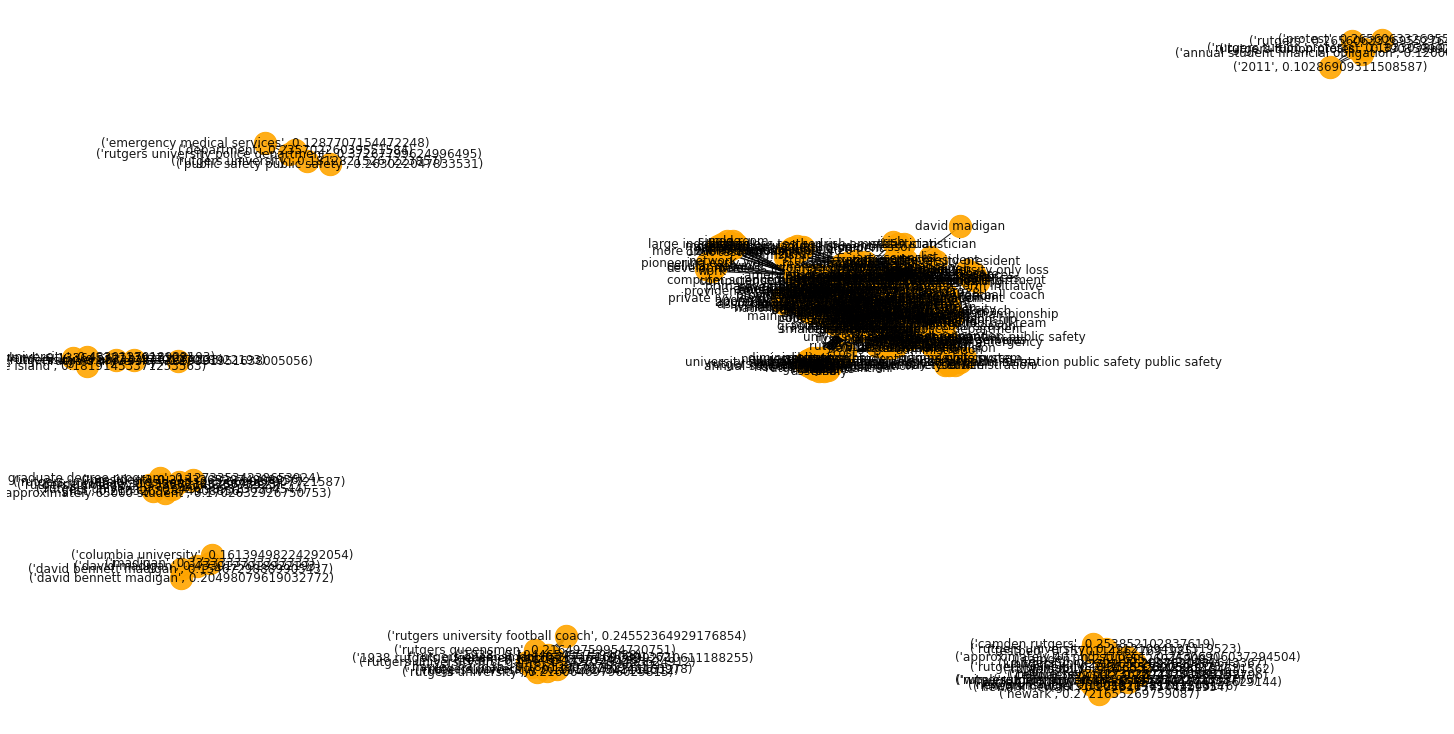

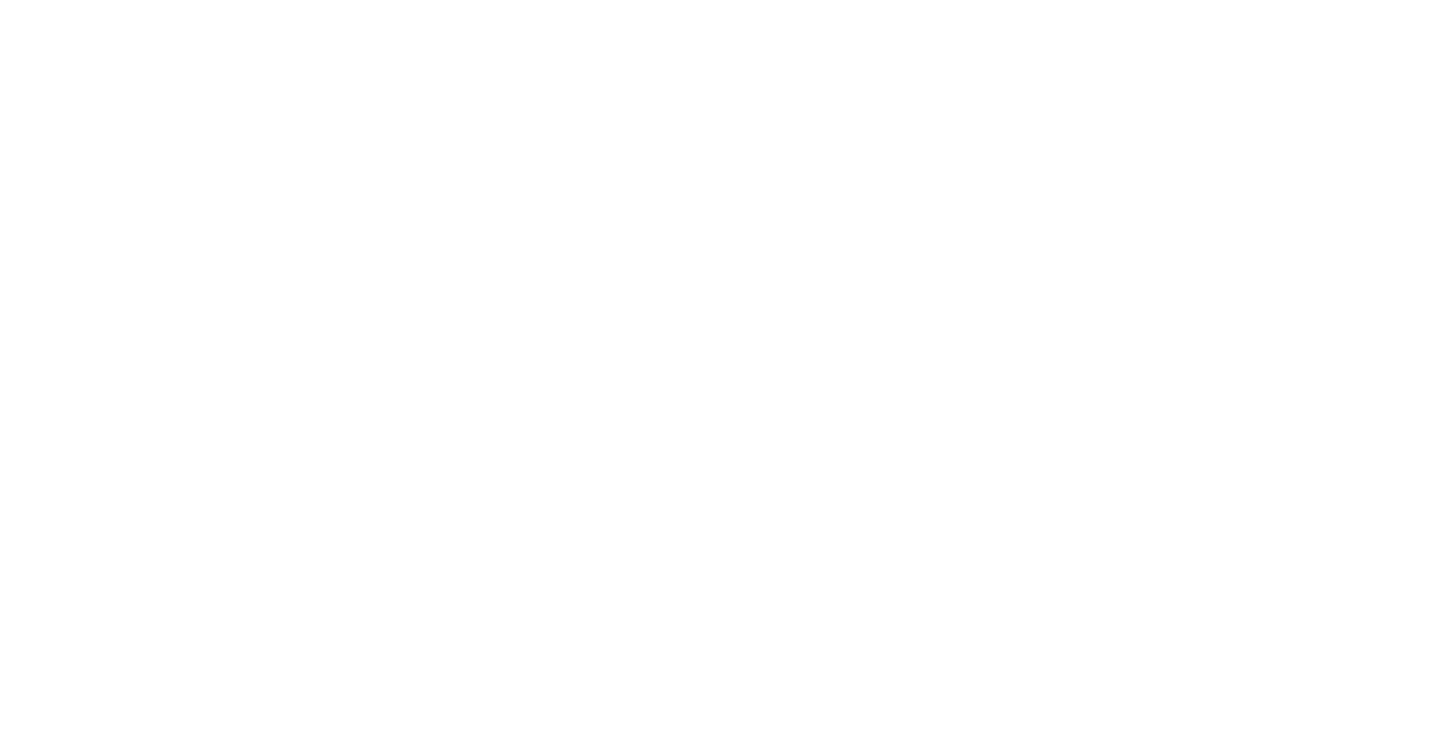

In [50]:
 
    RG = create_relevant_graph(paras_phrases, question_phrases_text)
    RG, common_phrases, mapping = find_common_mapping(RG, question_phrases_text)# mapping matchs paras_phrases with question_phrases
    RG, dup_sets = dedup_nodes_in_graph(RG, question_phrases_text)              # dedup paras_phrases in RG for finding meanningful path
#     print(black("nodes in RG: ", 'bold'), RG.nodes())
    
    question_only_phrase = list(set(question_phrases_text).difference(common_phrases)) 
    if(len(common_phrases) > 1): 
        path_phrases = list(approx.steinertree.steiner_tree(RG, common_phrases).nodes)  # to find the shortest path cover all common_phrases  
        extended_phrases = path_phrases + question_only_phrase  
    else: #  0 or 1 common phrases
        path_phrases = list(common_phrases)             
        extended_phrases = question_phrases_text

    
    print(black("common_phrases: ", 'bold'), common_phrases)
    print(black("path_phrases: ", 'bold'), path_phrases)     
    print(black("question_only_phrase: ", 'bold'), question_only_phrase)
    print(black("extended_phrases before expand", 'bold'), extended_phrases)
    

In [51]:
    # expand to include merged nodes, that is, also include phrases that from the same dup_set 
    extended_phrases_merged = set()
    for phrase in extended_phrases:
        idx_phrase = [idx for idx, dup_set in enumerate(dup_sets) if(phrase in dup_set)]   # the set where phrase in
        if(len(idx_phrase) > 0):
            extended_phrases_merged = extended_phrases_merged | dup_sets[idx_phrase[0]]
            extended_phrases_merged.remove(phrase)
    extended_phrases.extend(list(extended_phrases_merged))
    print(black("extended_phrases: ", 'bold'), extended_phrases)        
    print(black("introduced_phrases: ", 'bold'), set(extended_phrases) - set(question_phrases_text))
        

extended_phrases:  ['rutgers university brown university public', 'rutgers university brown university', 'public']
introduced_phrases:  set()


nodes to draw []


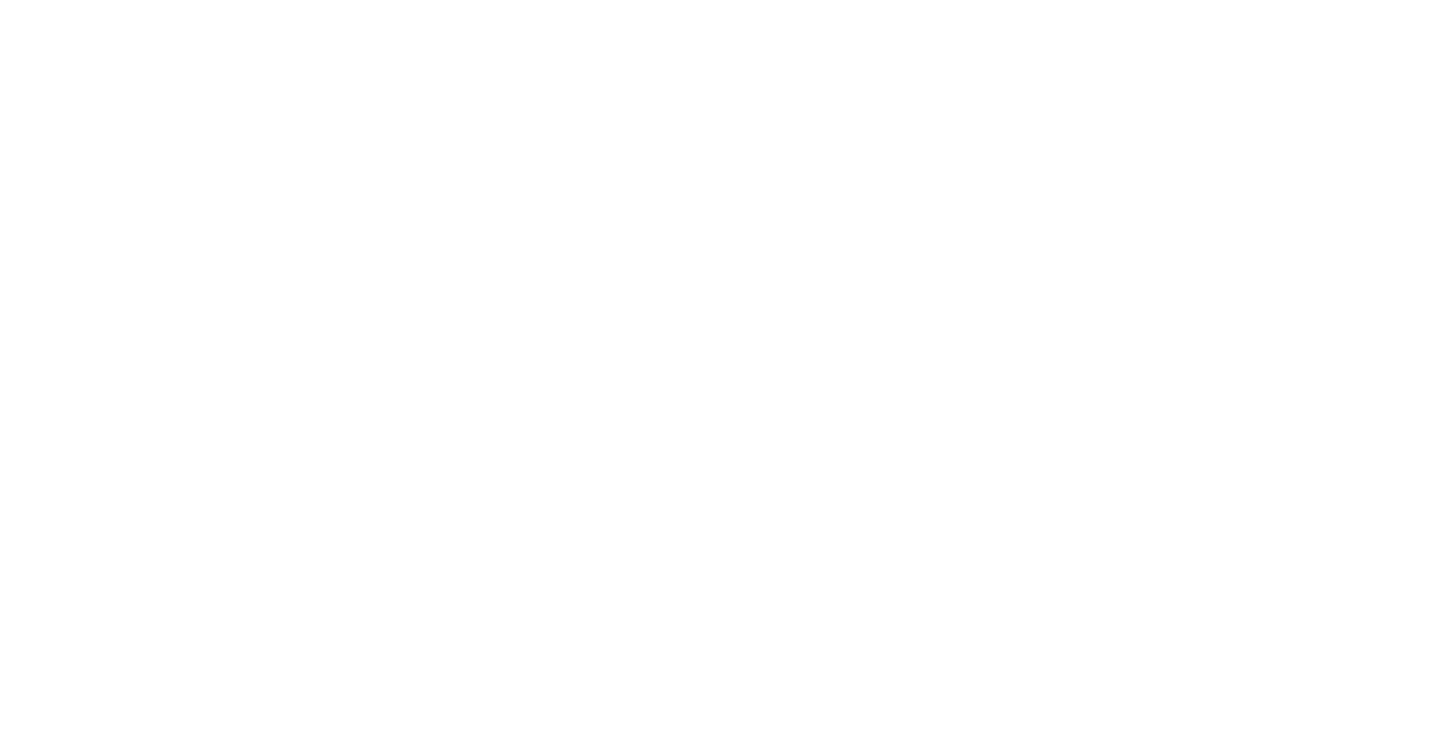

nodes to draw []


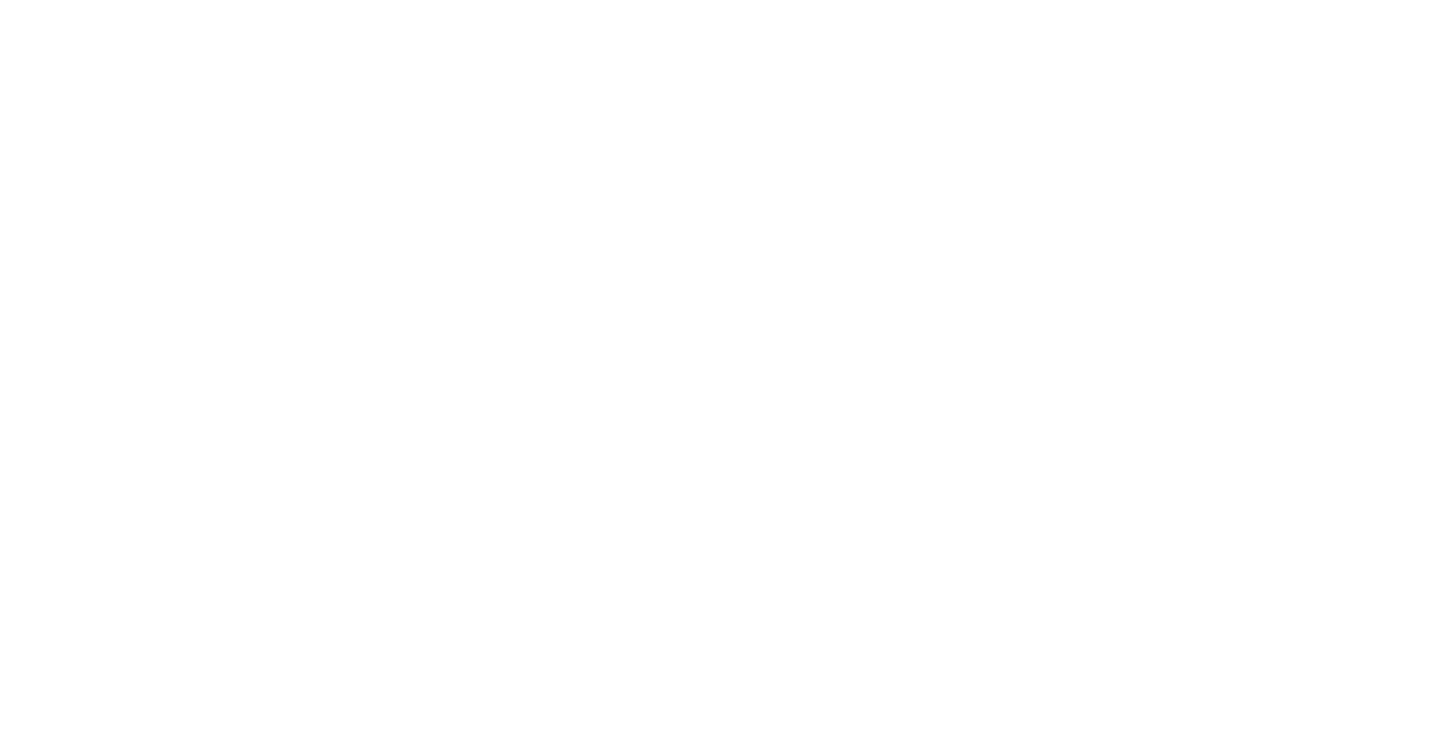

In [52]:
    vis_graph(RG, common_phrases, question_phrases_text) 
#     print(blue("Min Subgraph covers all common entities"))
    vis_graph(RG, path_phrases, question_phrases_text) 
        
#     print(black("phrases in relevant components", 'bold'))    
#     print(RG.nodes.data())
        
    

In [53]:
    
    raw_reduced_contexts, kept_para_sent = construct_reduced_context(raw_contexts, paras_phrases, extended_phrases, mapping)     
    reduced_contexts = [TITLE_START + ' ' + lst[0]  + ' ' + TITLE_END + ' ' + (' ' + SENT_MARKER_END +' ').join(lst[1]) + ' ' + SENT_MARKER_END for lst in raw_reduced_contexts]    
    reduced_context_str = remove_punc(lower(_normalize_text(" ".join(reduced_contexts)) )) 
    if (answer != '' and answer != 'yes'  and  answer != 'no' and len(list(re.finditer(answer, reduced_context_str, re.IGNORECASE))) > 0):
        print(black("answer in reduced_context", 'bold')) 
    elif(answer == 'yes' or answer == 'no'):
        pass
    else:
        print(black("answer not in reduced_context", 'bold')) 
        print(black("reduced_contexts", 'bold'), raw_reduced_contexts)
#     print(black('titles: ', 'bold'), titles) 
    
    reduced_supporting_facts, reduced_supporting_facts_in_original_id = construct_reduced_supporting_facts(example["supporting_facts"], raw_reduced_contexts, kept_para_sent) 
    for para_title, sent_id in example["supporting_facts"]:
        print(raw_contexts[titles.index(para_title)][1][sent_id])
    print(black('reduced_supporting_facts_in_original_id: ', 'bold'), reduced_supporting_facts_in_original_id) 
#     print(black('reduced supportiing facts: ', 'bold'), reduced_supporting_facts) 
    for para_title, sent_id in reduced_supporting_facts_in_original_id:
        print(raw_contexts[titles.index(para_title)][1][sent_id])
    
    example["question_phrases_text"] = question_phrases_text
    example["question_only_phrase"] = question_only_phrase
    P = RG.subgraph(path_phrases)  # to save the graph view that contains      
    path_data = json_graph.node_link_data(P)
    example["path"] = path_data
    example["question_phrases"] = question_phrases
    example["paras_phrases"] = paras_phrases
#     example["all_sent_phrases_text"] = all_sent_phrases_text
    example["common_phrases"] = list(common_phrases)
    example["path_phrases"] = path_phrases
    example["extended_phrases"] = extended_phrases                     
    example['context'] = raw_reduced_contexts
    example['supporting_facts'] = reduced_supporting_facts
    example['kept_para_sent'] = kept_para_sent

    print(black("context: ", 'bold'), raw_contexts)   
    print(black("reduced_context: ", 'bold'), raw_reduced_contexts)   

reduced_context_ratio 0.0
answer not in reduced_context
reduced_contexts []
supportiing facts:  {('Brown University', 0), ('Rutgers University', 0)}
Rutgers, The State University of New Jersey ( ), commonly referred to as Rutgers University, Rutgers, or RU, is an American public research university and the largest institution for higher education in New Jersey.
Brown University is a private Ivy League research university in Providence, Rhode Island, United States.
reduced_supporting_facts_in_original_id:  []
context:  [['1938 Rutgers Queensmen football team', ['The 1938 Rutgers Queensmen football team represented Rutgers University in the 1938 college football season.', " In February 1938, Rutgers announced Tasker's resignation as Rutgers' football coach and his replacement by Harvey Harman.", ' In their first season under coach Harman, the Queensmen compiled a 7–1 record, won the Middle Three Conference championship, and outscored their opponents 118 to 57.', ' Rutgers only loss was t

### Sandbox

In [54]:
title = "chris jones footballer born 1985"
sents =  ['chris is welsh semiprofessional footballer currently playing for cymru alliance side porthmadog', 'former professional with leeds united jones is currently in his fourth season with city', 'he made several appearances for leeds and was heavily involved with first team', 'chris was playing with likes of aaron lennon james milner rio ferdinand scott carson and alan smith during his spell with yorkshire outfit']

In [55]:
context = title  + ' ' + TITLE_END + ' ' + (' ' + SENT_MARKER_END +' ').join(sents)

In [56]:
context_doc = nlp1(context)
title, sents = context_doc._.coref_resolved.split(TITLE_END)  
sents = sents.split(SENT_MARKER_END)
sent_docs = list(nlp2.pipe([title] + sents))     

In [57]:
context_doc._.coref_resolved

'chris born 1985 , </t> .  chris is welsh semiprofessional footballer currently playing for cymru alliance side porthmadog , </sent> ,  former professional with leeds united jones is currently in welsh semiprofessional footballer currently playing for cymru alliance side porthmadog , </sent> ,  former professional with leeds united jones fourth season with city , </sent> ,  welsh semiprofessional footballer currently playing for cymru alliance side porthmadog , </sent> ,  former professional with leeds united jones made several appearances for leeds united jones and was heavily involved with first team , </sent> ,  chris was playing with likes of aaron lennon james milner rio ferdinand scott carson and alan smith during welsh semiprofessional footballer currently playing for cymru alliance side porthmadog , </sent> ,  former professional with leeds united jones spell with yorkshire outfit'

In [31]:
context = "brown state fishing lake , </t> .  brown state fishing lake sometimes also known as brown state fishing lake and wildlife area is protected area in brown county kansas in united states , </sent> ,  lake is 62 acres 025 km² in area and up to 13 feet 4 m deep , </sent> ,  area was formerly known as brown county state park and is 8 miles 13 km east of hiawatha kansas"
 

In [32]:
context_doc = nlp1(context)
print(context_doc._.coref_resolved)
print(context_doc._.coref_clusters)
print(context_doc._.coref_clusters[1].mentions)
print(context_doc._.coref_clusters[1].mentions[-1])
print(context_doc._.coref_clusters[1].mentions[-1]._.coref_cluster.main)

brown state fishing lake , </t> .  brown state fishing lake sometimes also known as brown state fishing lake and wildlife area is protected area in brown county kansas in united states , brown state fishing lake is 62 acres 025 km² in area and up brown state fishing lake and wildlife area was formerly known as brown county state park and is 8 miles 13 km east of hiawatha kansas
[brown: [brown, brown], brown state fishing lake: [brown state fishing lake, brown state fishing lake, </sent> ,  lake], brown state fishing lake and wildlife area: [brown state fishing lake and wildlife area, to 13 feet 4 m deep , </sent> ,  area], brown county: [brown county, brown county], kansas: [kansas, kansas]]
[brown state fishing lake, brown state fishing lake, </sent> ,  lake]
</sent> ,  lake
brown state fishing lake


In [33]:
context = "fishing lake , </t> .  fishing lake is lake in canadian province of saskatchewan , </sent> ,  lake is located between highway 5 and highway 16 22 km north of town of foam lake saskatchewan and 24 km east of town of wadena saskatchewan , </sent> ,  lake does not have effective outlet channel and so is prone to flooding , </sent> ,  record floods in 2007 resulted in plan by government of saskatchewan to lower level of lake by digging drainage channel , </sent> ,  fishing lake first nation opposed this plan and instead flood control berms were constructed"
context_resolved = nlp1(context)._.coref_resolved

print(context_resolved)
title_coref_resolved, sents_coref_resolved = context_resolved.split(TITLE_END)  
sents_coref_resolved = sents_coref_resolved.split(SENT_MARKER_END) 
sent_docs = list(nlp2.pipe([title_coref_resolved] + sents_coref_resolved))     
para_phrases = []                                        
for sent_doc in sent_docs:                                    # each sent in a para
    sent_phrases = [(p.text, p.rank) for p in sent_doc._.phrases if(p.text != '')]  # phrases from each sentence 
    para_phrases.append(sent_phrases)     
print(para_phrases)
print("\n")  

fishing lake , </t> .  fishing lake is lake in canadian province of saskatchewan , </sent> ,  lake is located between highway 5 and highway 16 22 km north of town of foam lake saskatchewan and 24 km east of town of wadena saskatchewan , </sent> ,  lake does not have effective outlet channel and so is prone to flooding , </sent> ,  record floods in 2007 resulted in plan by government of saskatchewan to lower level of fishing lake by digging drainage channel , </sent> ,  lake saskatchewan opposed this plan and instead flood control berms were constructed
[[('fishing lake', 0.4330127018922193), ('lake', 0.3333333333333333)], [('canadian province', 0.2616585242462876), ('lake', 0.23150520948869216), ('province', 0.20142482587913918), ('canadian', 0.20142482587913918), ('saskatchewan', 0.16895618538601082), ('fishing lake', 0.13160696215647302)], [('16 22 km', 0.2026452065409755), ('24 km', 0.18671728907198992), ('foam lake saskatchewan', 0.1852953057904101), ('lake saskatchewan', 0.1764118

In [34]:
from spacy.tokens import Span
text = 'valhalla highlands historic district also known as lake valhalla is national historic district located near cold spring in putnam county new york'
doc = nlp2(text)
for chunk in doc.noun_chunks:
    print('chunk: ', chunk.text) 
    print('root: ',  chunk.root.text)
#     span = Span(doc, chunk.root.i, chunk.root.i+1)
#     print(span)
#     print(span.start)

chunk:  valhalla highlands historic district
root:  district
chunk:  lake valhalla
root:  valhalla
chunk:  national historic district
root:  district
chunk:  cold spring
root:  spring
chunk:  putnam county new york
root:  york


In [35]:
context = "this list provides guide to opera composers as determined by their presence on majority of compiled lists of significant opera composers , </sent> ,  see lists consulted section for full details , </sent> ,  composers run from jacopo peri who wrote first ever opera in late 16th century italy to john adams one of leading figures in contemporary operatic world , </sent> ,  brief accompanying notes offer explanation as to why each composer has been considered major , </sent> ,  also included is section about major women opera composers compiled from same lists , </sent> ,  for introduction to operatic history see opera , </sent> ,  organisation of list is by birthdate"
context_resolved = nlp1(context)._.coref_resolved

print(context_resolved)
sents_coref_resolved = context_resolved.split(SENT_MARKER_END)  

this list provides guide to opera composers as determined by opera composers presence on majority of compiled lists of significant opera composers , </sent> ,  see lists consulted section for full details , </sent> ,  composers run from jacopo peri who wrote first ever opera in late 16th century italy to john adams one of leading figures in contemporary operatic world , </sent> ,  brief accompanying notes offer explanation as to why each composer has been considered major , </sent> ,  also included is section about major women opera composers compiled from same lists , </sent> ,  for introduction to operatic history see opera , </sent> ,  organisation of list is by birthdate


In [36]:
import pandas as pd
train_df = pd.read_csv('../LIME/dreaddit-train.csv') 
test_df = pd.read_csv('../LIME/dreaddit-test.csv') 

train_df = train_df.loc[train_df.confidence>0.8]

train_df["coref_resolved"] = train_df["text"]
for i, train_text in enumerate(train_df.text.values.tolist()):
    train_sents_doc = nlp1(_normalize_text(train_text))
    train_df["coref_resolved"].iloc[i] = train_sents_doc._.coref_resolved

/home/u32/fanluo/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [37]:
train_df.to_csv("../LIME/dreaddit-train_resolved.csv") 

In [38]:
test_df = test_df.loc[test_df.confidence>0.8]

test_df["coref_resolved"] = test_df["text"]
for i, test_text in enumerate(test_df.text.values.tolist()):
    test_sents_doc = nlp1(_normalize_text(test_text))
    test_df["coref_resolved"].iloc[i] = test_sents_doc._.coref_resolved

/home/u32/fanluo/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [39]:
test_df.coref_resolved.iloc[20]

'His consequences will never reflect or equate to the suffering I have endured and the life-long trauma that will impede on the rest of my life, Because on March 21st and 22nd in 2017, my humanity was shaken and distorted in ways that I still struggle to resolve, His consequences exists in the shadows of nightmares I still have of His face, His screams, His weapons, His murder threats, suicide threats, and fists, His consequences is perpetuated by the adrenaline and primal fear I have I see vehicles that look like His, It is in my mind I have to loop around my neighborhood before going home, out of fear that I will see His, because His ONLY lives 5 minutes from me,'

In [40]:
test_df.text.iloc[20]

'His consequences will never reflect or equate to the suffering I have endured and the life-long trauma that will impede on the rest of my life. Because on March 21st and 22nd in 2017, my humanity was shaken and distorted in ways that I still struggle to resolve. It exists in the shadows of nightmares I still have of his face, his screams, his weapons, his murder threats, suicide threats, and fists. It is perpetuated by the adrenaline and primal fear I have when I see vehicles that look like his. It is in my mind when I have to loop around my neighborhood before going home, out of fear that I will see him, because he ONLY lives 5 minutes from me.'

In [41]:
    
test_df.to_csv("../LIME/dreaddit-test_resolved.csv")    